In [ ]:
!rm -rf *.png out.zip

In [ ]:
opt_name = "preact_resnet"

#Fold vs Prune and Ablations

In [ ]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib import colormaps
from pathlib import Path
import seaborn as sns

In [ ]:
# Load text content
with open(f"fold", "r") as f:
    fold_text = f.read()
with open(f"mag-l1", "r") as f:
    mag1_text = f.read()
with open(f"mag-l2", "r") as f:
    mag2_text = f.read()

In [ ]:
def extract_data(text, include=None, exclude=None, keep_extra=False):
    """
    Parse log `text` into a DataFrame with rows for BASE (sparsity=0.0) and PRUNE/REPAIR pairs.
    Supports filtering by base_acc (acc_before), lr, l1, wd, augmentations (rand_aug), and sam.

    Columns (at least): model_id | model | sparsity | acc_before | acc_after | l1 | wd | lr | rand_aug | sam
    """
    import re, pandas as pd

    rows = []
    block_re = re.compile(r"\[MODEL\]\s+(\d+)/\d+\s+(.*?)\.pth(.*?)(?=\[MODEL\]|\Z)", re.DOTALL)

    def tok(name, key, default=None):
        # match tokens like ..._key=VALUE_... (VALUE may be number or True/False)
        m = re.search(rf"(?:^|[_-]){key}=([A-Za-z0-9+.\-eE]+|True|False)(?=[_-]|$)", name)
        if not m: return default
        v = m.group(1)
        vl = v.lower()
        if vl in ("true","false"): return vl == "true"
        try:
            if re.fullmatch(r"[+-]?\d+", v): return int(v)
            return float(v)
        except:
            return v

    # keys we care about (add more if needed)
    keys = ("lr","l1","wd","rand_aug","sam","sam_rho","lr_schedule","opt","dataset","arch","seed","batch_size","epochs","momentum")

    for mid, name, block in block_re.findall(text):
        mid = int(mid)
        kv = {k: tok(name, k) for k in keys}

        base = re.search(r"RATIO=0\.0\s+EVENT=BASE\s+params=(\d+)\s+acc=([0-9.]+)", block)
        if not base:
            continue
        base_params, base_acc = int(base.group(1)), float(base.group(2))

        # BASE row (sparsity 0.0)
        base_row = dict(model_id=mid, model=name, sparsity=0.0,
                        acc_before=base_acc, acc_after=base_acc, **kv if keep_extra else {})
        # always keep these common hparams even if keep_extra=False
        for k in ("l1","wd","lr","rand_aug","sam"):
            base_row[k] = kv.get(k)
        rows.append(base_row)

        # PRUNE/REPAIR pairs (match by ratio)
        prunes  = {float(r):(int(p), float(a)) for r,p,a in re.findall(
            r"RATIO=([0-9.]+)\s+EVENT=PRUNE\s+params=(\d+)\s+acc=([0-9.]+)", block)}
        repairs = {float(r):float(a) for r,a in re.findall(
            r"RATIO=([0-9.]+)\s+EVENT=REPAIR\s+acc=([0-9.]+)", block)}
        for r in sorted(set(prunes) & set(repairs)):
            pruned_params, _ = prunes[r]
            sparsity = 1.0 - pruned_params / base_params
            row = dict(model_id=mid, model=name, sparsity=sparsity, ratio=float(r),
                       acc_before=base_acc, acc_after=repairs[r], **kv if keep_extra else {})
            for k in ("l1","wd","lr","rand_aug","sam"):
                row[k] = kv.get(k)
            rows.append(row)

    df = pd.DataFrame(rows)
    if df.empty: return df

    # Normalize dtypes for filtering
    for col in ("wd","l1","lr","acc_before","acc_after","sparsity"):
        if col in df: df[col] = pd.to_numeric(df[col], errors="coerce")
    for col in ("rand_aug","sam"):
        if col in df: df[col] = df[col].astype("boolean")

    # alias map so include/exclude can use intuitive names
    alias = {"base_acc": "acc_before", "augmentations": "rand_aug", "aug": "rand_aug"}
    def _col(k): return alias.get(k, k)

    # filtering
    def _match(s, cond):
        if callable(cond): return s.map(cond).fillna(False)
        if isinstance(cond, (list, tuple, set)): return s.isin(cond)
        return s == cond

    if include:
        m = pd.Series(True, index=df.index)
        for k, c in include.items():
            col = _col(k)
            if col in df: m &= _match(df[col], c)
        df = df[m]
    if exclude:
        m = pd.Series(False, index=df.index)
        for k, c in exclude.items():
            col = _col(k)
            if col in df: m |= _match(df[col], c)
        df = df[~m]

    return df.reset_index(drop=True)


500 500 500


/tmp/ipython-input-2921265655.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


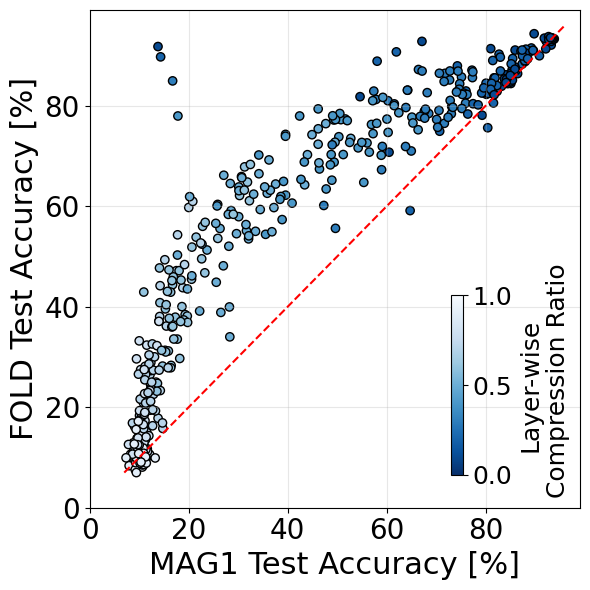

/tmp/ipython-input-2921265655.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


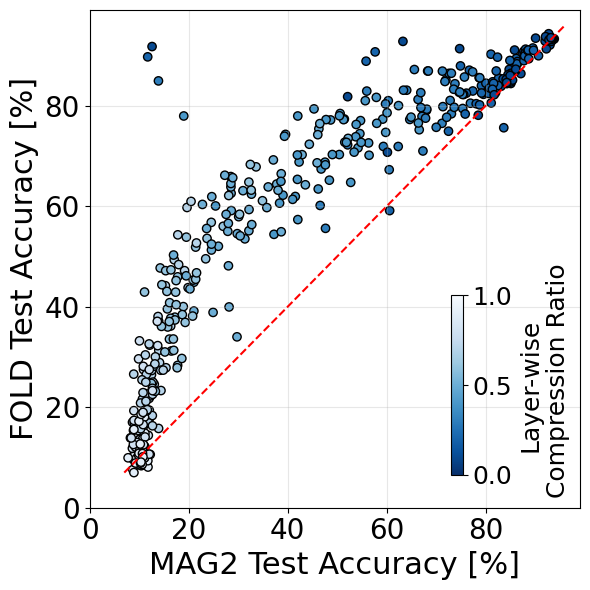

In [ ]:
def plot_compration_ratio_scatter(x_df, y_df, x_name, y_name):
    # Rename
    x_df = x_df.rename(columns={"acc_after": "acc_x"})
    y_df = y_df.rename(columns={"acc_after": "acc_y"})
    # Reduce and merge
    x_df = x_df[["model_id","model","ratio","acc_x"]]
    y_df = y_df[["model_id","model","ratio","acc_y"]]

    merged = pd.merge(y_df, x_df, on=["model_id","model","ratio"])
    norm = plt.Normalize(0.0, 1.0)   # full [0,1] range
    cmap = cm.Blues_r

    fig, ax = plt.subplots(figsize=(6,6))
    sc = ax.scatter(
        merged["acc_x"], merged["acc_y"],
        c=merged["ratio"], cmap=cmap, norm=norm,
        marker="o", edgecolor="black"
    )

    lo, hi = merged[["acc_x","acc_y"]].min().min(), merged[["acc_x","acc_y"]].max().max()
    ax.plot([lo,hi],[lo,hi],"r--",label="y = x")

    ax.set_xlabel(f"{x_name} Test Accuracy [%]", fontsize=22)
    ax.set_ylabel(f"{y_name} Test Accuracy [%]", fontsize=22)
    ax.tick_params(axis="both", labelsize=20)
    ax.grid(True, alpha=0.3)
    ax.set_xlim(0, 99)
    ax.set_ylim(0, 99)

    # Colorbar

    cbar_ax = fig.add_axes([0.76, 0.20, 0.02, 0.3])
    smap = cm.ScalarMappable(norm=norm, cmap=cmap)
    cbar = fig.colorbar(smap, cax=cbar_ax, ax=ax, fraction=0.035, pad=0.02)
    cbar.set_label("Layer-wise\n Compression Ratio", fontsize=18)
    cbar.ax.tick_params(labelsize=18)

    fig.tight_layout()
    fig.savefig(f"{opt_name}__compression_ratio_scatter__{x_name}_vs_{y_name}.png", dpi=100)
    plt.show()


# --- Extract ---
fold_df  = extract_data(fold_text)
mag1_df = extract_data(mag1_text)
mag2_df = extract_data(mag2_text)

# Print
print(len(fold_df), len(mag1_df), len(mag2_df))

plot_compration_ratio_scatter(mag1_df, fold_df, "MAG1", "FOLD")
plot_compration_ratio_scatter(mag2_df, fold_df, "MAG2", "FOLD")

/tmp/ipython-input-588909607.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{v:.2f}" for v in order], rotation=45, ha="right")


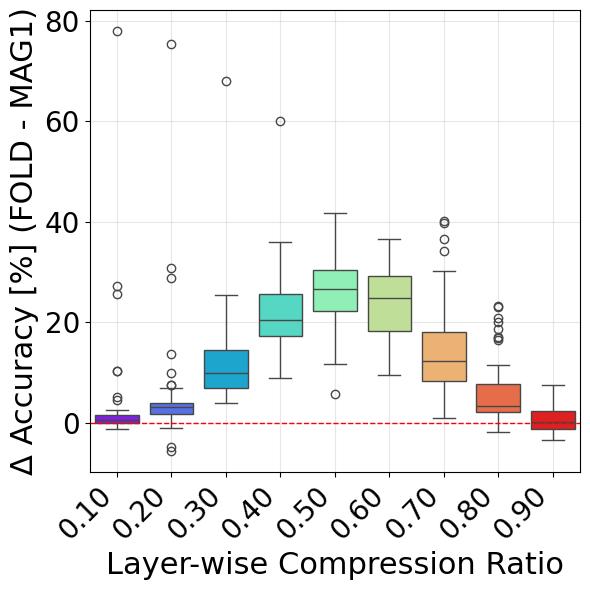

/tmp/ipython-input-588909607.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{v:.2f}" for v in order], rotation=45, ha="right")


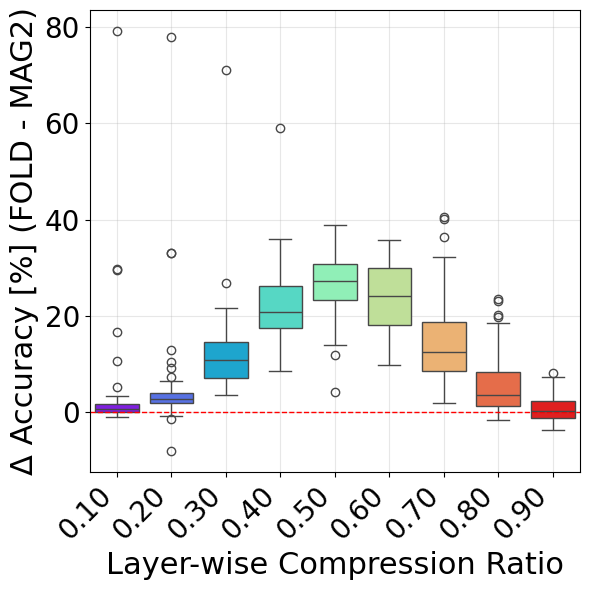

In [ ]:
# rename once (robust)
for df, newcol in [(fold_df, "acc_fold"), (mag1_df, "acc"), (mag2_df, "acc")]:
    if "acc_after" in df.columns:
        df.rename(columns={"acc_after": newcol}, inplace=True)

for method_name, method_df in [("MAG1", mag1_df), ("MAG2", mag2_df)]:
    merged = pd.merge(
        fold_df[["model", "ratio", "acc_fold"]],
        method_df[["model", "ratio", "acc"]],
        on=["model", "ratio"],
        how="inner",
    )
    if merged.empty:
        continue

    # accuracy gain (FOLD - MAG)
    merged["relative_diff"] = merged["acc_fold"] - merged["acc"]
    box = merged[["ratio", "relative_diff"]].copy()

    # use 2-dp categories for x-axis (and colors)
    box["s2"] = box["ratio"].round(2)
    order = sorted(box["s2"].unique())
    order = order[1:]

    # consistent palette per sparsity
    cmap = colormaps["rainbow"]
    colors = [cmap(0.0 + 1.0 * i / max(len(order) - 1, 1)) for i in range(len(order))]
    pal = dict(zip(order, colors))

    fig, ax = plt.subplots(figsize=(6, 6))
    sns.boxplot(
        data=box, x="s2", y="relative_diff",
        order=order, hue="s2", palette=pal, dodge=False, legend=False, ax=ax
    )

    ax.axhline(0, color="red", linestyle="--", linewidth=1)
    ax.set_xlabel("Layer-wise Compression Ratio", fontsize=22)
    ax.set_ylabel(f"Δ Accuracy [%] (FOLD - {method_name})", fontsize=22)
    ax.tick_params(axis="both", labelsize=20)
    ax.set_xticklabels([f"{v:.2f}" for v in order], rotation=45, ha="right")
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    fig.savefig(f"{opt_name}__compression_ratio_hist__{method_name}_vs_FOLD.png", dpi=100)
    plt.show()


In [ ]:
def format_lr_label(lr, tol=1e-12):
    if lr is None or np.isnan(lr) or lr <= 0:
        return "LR=?"
    # power-of-ten?
    exp_rounded = int(round(np.log10(lr)))
    if np.isclose(lr, 10**exp_rounded, rtol=0, atol=tol):
        return rf"LR=$10^{{{exp_rounded}}}$"
    # general scientific form m × 10^n
    exp = int(np.floor(np.log10(lr)))
    mant = lr / (10**exp)
    mant_str = f"{mant:.0f}" if np.isclose(mant, round(mant), atol=tol) else f"{mant:.2g}"
    return rf"LR=${mant_str}\times 10^{{{exp}}}$"

/tmp/ipython-input-1440683916.py:91: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


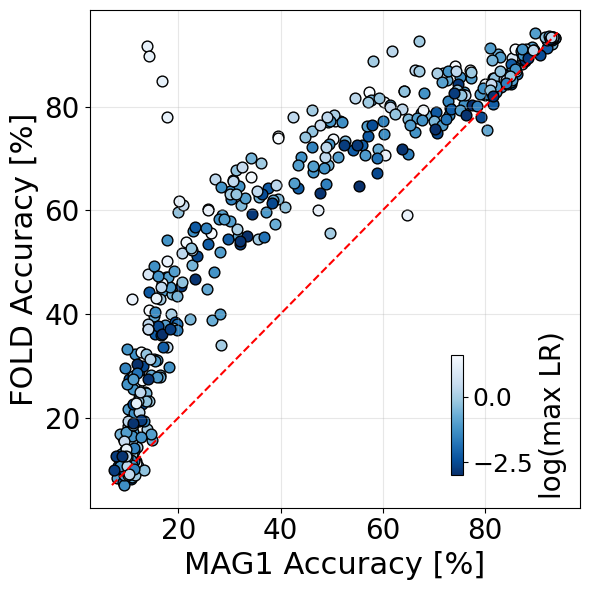

/tmp/ipython-input-1440683916.py:91: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


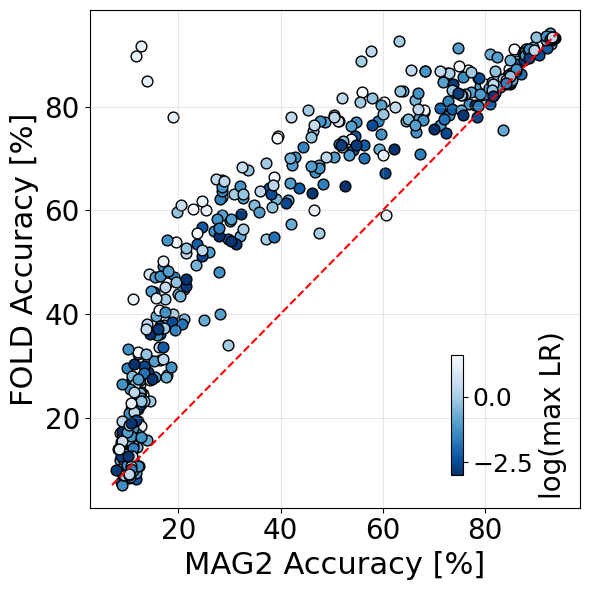

In [ ]:
# --- Extract hyperparameters from filename ---
def extract_l1_lr_wd_sched(name):
    l1_match = re.search(r"l1=([0-9.eE+-]+)", name)
    lr_match = re.search(r"lr(?:_max)?=([0-9.eE+-]+)", name)  # Match lr or lr_max
    wd_match = re.search(r"wd=([0-9.eE+-]+)", name)
    sched_match = re.search(r"lr_schedule=(True|False|cyclic|none)", name)

    l1 = float(l1_match.group(1)) if l1_match else None
    lr = round(float(lr_match.group(1)), 8) if lr_match else None
    wd = round(float(wd_match.group(1)), 8) if wd_match else 0.0
    lr_schedule = sched_match.group(1).lower() in ["true", "cyclic"] if sched_match else False

    return l1, lr, wd, lr_schedule

def extract_data_with_lr(text):
    pat = re.compile(r"\[MODEL\]\s+(\d+)/\d+\s+(.*?epoch=\d+\.pth)(.*?)(?=\[MODEL\]|\Z)", re.DOTALL)
    rows = []
    for m in pat.finditer(text):
        model_id, name, block = int(m[1]), m[2].strip(), m[3]
        l1, lr, wd, sched = extract_l1_lr_wd_sched(name)
        base = re.search(r"RATIO=0\.0\s+EVENT=BASE params=(\d+)\s+acc=([0-9.]+)", block)
        if not base: continue
        base_params, base_acc = int(base[1]), float(base[2])
        prunes = re.findall(r"RATIO=([0-9.]+)\s+EVENT=PRUNE params=(\d+)\s+acc=([0-9.]+)", block)
        repairs = re.findall(r"RATIO=([0-9.]+)\s+EVENT=REPAIR acc=([0-9.]+)", block)
        for (rp, pp, _), (rr, acc_r) in zip(prunes, repairs):
            if abs(float(rp)-float(rr))<1e-4:
                sparsity = round(1 - int(pp)/base_params, 3)
                rows.append((model_id, name, sparsity, float(rp), base_acc, float(acc_r), l1, lr, wd, sched))
    df = pd.DataFrame(rows, columns=["model_id","model","sparsity", "ratio", "acc_before","acc_after","l1","lr","wd","lr_schedule"])
    df["model"] = df["model"].str.strip()
    df[["sparsity","l1","wd"]] = df[["sparsity","l1","wd"]].round(5)
    return df


# --- Load and Merge ---
fold_df = extract_data_with_lr(fold_text).rename(columns={"acc_after": "acc_fold"})
mag1_df = extract_data_with_lr(mag1_text).rename(columns={"acc_after": "acc"})
mag2_df = extract_data_with_lr(mag2_text).rename(columns={"acc_after": "acc"})

for df in [fold_df, mag1_df, mag2_df]:
    df["model"] = df["model"].str.strip()
    df["sparsity"] = df["sparsity"].round(3)

# --- Setup legends ---
schedule_to_marker = {True: 'o', False: 'P'}
marker_labels = {True: "With LR Schedule", False: "No LR Schedule"}

# --- Plotting for MAG-L1 and MAG-L2 ---
for method_name, method_df in zip(("MAG1", "MAG2"), (mag1_df, mag2_df)):
    merged_df = pd.merge(
        fold_df[["model", "sparsity", "acc_fold", "lr"]],
        method_df[["model", "sparsity", "acc", "lr"]],
        on=["model", "sparsity", "lr"]
    )

    if merged_df.empty:
        print(f"Warning: No matching models for {method_name}")
        continue

    # Normalize learning rate for color
    lr_vals = np.log(merged_df["lr"].values)
    norm = mcolors.Normalize(vmin=lr_vals.min(), vmax=lr_vals.max())
    cmap = cm.Blues_r

    fig, ax = plt.subplots(figsize=(6, 6))

    for _, row in merged_df.iterrows():
        color = cmap(norm(np.log(row["lr"])))
        ax.scatter(row["acc"], row["acc_fold"], c=[color], marker='o', edgecolor="black", s=60)

    # Diagonal reference line
    min_val = min(merged_df["acc"].min(), merged_df["acc_fold"].min())
    max_val = max(merged_df["acc"].max(), merged_df["acc_fold"].max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--')

    ax.set_xlabel(f"{method_name} Accuracy [%]", fontsize=22)
    ax.set_ylabel("FOLD Accuracy [%]", fontsize=22)
    ax.tick_params(axis='both', labelsize=20)

    # --- Colorbar for learning rate ---
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar_ax = fig.add_axes([0.76, 0.20, 0.02, 0.2])
    smap = cm.ScalarMappable(norm=norm, cmap=cmap)
    cbar = fig.colorbar(smap, cax=cbar_ax, ax=ax, fraction=0.035, pad=0.02)
    cbar.set_label("log(max LR)", fontsize=20)
    cbar.ax.tick_params(labelsize=18)
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    fig.savefig(f"{opt_name}__lr_scatter__{method_name}_vs_FOLD.png", dpi=100)
    plt.show()


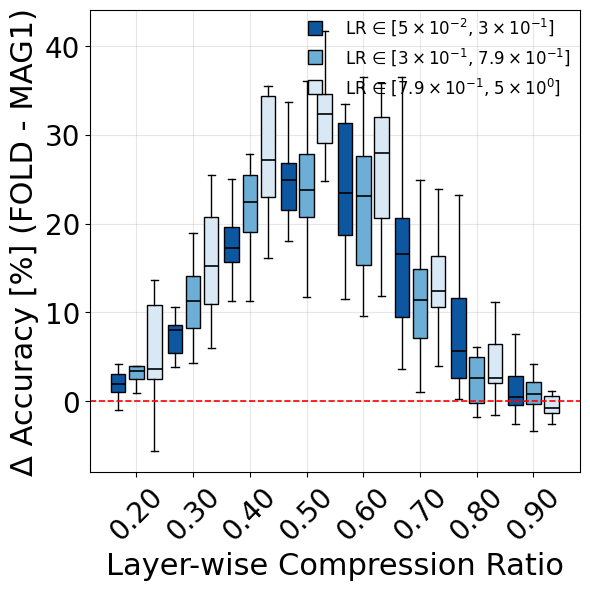

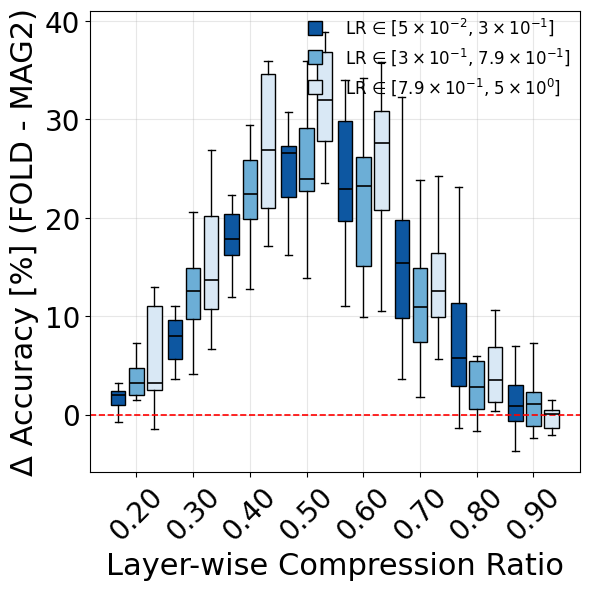

In [ ]:
def plot_fold_vs_method_box_by_ratio_lr():
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    from matplotlib import cm

    # ---- helpers ----
    def grouped_positions(x_vals, n_groups, width=0.18):
        offsets = np.linspace(-((n_groups-1)/2)*width, ((n_groups-1)/2)*width, n_groups)
        return {gi: (np.asarray(x_vals) + offsets[gi]) for gi in range(n_groups)}, width

    def _fmt_10pow(x, tol=1e-12):
        """Format scalar x > 0 as 10^n or m×10^n (LaTeX)."""
        if x is None or np.isnan(x) or x <= 0:
            return r"? "
        n = int(np.floor(np.log10(x)))
        m = x / (10**n)
        if np.isclose(m, 1.0, atol=tol):
            return rf"$10^{{{n}}}$"
        mant = f"{m:.0f}" if np.isclose(m, round(m), atol=tol) else f"{m:.2g}"
        return rf"${mant}\times 10^{{{n}}}$"

    # --- plotting (with LR binning) ---
    for method_name, method_df in zip(["MAG1","MAG2"], [mag1_df, mag2_df]):
        # merge
        merged = pd.merge(
            fold_df[["model","ratio","acc_fold"]],
            method_df[["model","ratio","acc"]],
            on=["model","ratio"], how="inner"
        )
        if merged.empty:
            continue

        to_num = lambda s: pd.to_numeric(s, errors="coerce")
        # parse learning rate (named 'lr_max' in your filenames)
        merged["lr"] = to_num(merged["model"].str.extract(r"lr_max=([0-9.eE+-]+)", expand=False))

        # filter + compute delta
        subset = merged.dropna(subset=["lr"]).copy()
        # subset = subset[subset["lr"] > 0]  # valid LRs only
        if subset.empty:
            continue

        subset["diff"] = subset["acc_fold"] - subset["acc"]

        # --- bin LR into 3 subranges on log-scale ---
        loglr = np.log10(subset["lr"])
        try:
            subset["lr_bin"] = pd.qcut(loglr, q=3, duplicates="drop")
        except ValueError:
            lo, hi = loglr.min(), loglr.max()
            if not np.isfinite(lo) or not np.isfinite(hi) or lo == hi:
                # cannot bin a single unique value
                continue
            edges = np.linspace(lo, hi, 4)
            subset["lr_bin"] = pd.cut(loglr, bins=edges, include_lowest=True)
        if subset["lr_bin"].isna().all():
            continue

        # ordered categories & colors
        bin_cats = subset["lr_bin"].cat.categories
        n_bins = len(bin_cats)
        if n_bins == 0:
            continue
        bin_colors = cm.Blues_r(np.linspace(0.15, 0.85, n_bins))
        bin_to_color = {b: c for b, c in zip(bin_cats, bin_colors)}

        # figure (single panel)
        fig, ax = plt.subplots(1, 1, figsize=(6, 6), sharey=True)

        all_ratios = sorted(subset["ratio"].unique())
        # optional: drop the first ratio like in your earlier code
        if len(all_ratios) > 1:
            all_ratios = all_ratios[1:]
        if not all_ratios:
            plt.close(fig)
            continue

        x = np.arange(len(all_ratios), dtype=float)
        pos_map, box_w = grouped_positions(x, n_groups=n_bins, width=0.32)

        # boxplots per (ratio, LR-bin) -- USE 'subset' consistently
        for gi, bin_cat in enumerate(bin_cats):
            pos = pos_map[gi]
            data_for_boxes, valid_pos = [], []
            for r_i, r in enumerate(all_ratios):
                vals = subset[(subset["ratio"] == r) & (subset["lr_bin"] == bin_cat)]["diff"].tolist()
                if vals:
                    data_for_boxes.append(vals)
                    valid_pos.append(pos[r_i])
            if data_for_boxes:
                bp = ax.boxplot(
                    data_for_boxes,
                    positions=valid_pos,
                    widths=box_w*0.8,
                    patch_artist=True,
                    showfliers=False
                )
                for patch in bp["boxes"]:
                    patch.set(facecolor=bin_to_color[bin_cat], alpha=1.0, edgecolor="black")
                for whisk in bp["whiskers"]:
                    whisk.set(color="black", linewidth=1)
                for cap in bp["caps"]:
                    cap.set(color="black", linewidth=1)
                for median in bp["medians"]:
                    median.set(color="black", linewidth=1.2)

        # aesthetics
        ax.set_xlabel("Layer-wise Compression Ratio", fontsize=22)
        ax.set_xticks(x)
        ax.set_xticklabels([f"{r:.2f}" if isinstance(r, float) else str(r) for r in all_ratios],
                           rotation=45, fontsize=20)
        ax.axhline(0.0, color="red", linestyle="--", linewidth=1.2)  # accuracy gain = 0
        ax.tick_params(axis="y", labelsize=20)
        ax.grid(True, alpha=0.3)
        ax.set_ylabel(f"Δ Accuracy [%] (FOLD - {method_name})", fontsize=22)

        # Legend with LR bin ranges (formatted as 10^n)
        handles = []
        for gi, bin_cat in enumerate(bin_cats):
            left_log, right_log = float(bin_cat.left), float(bin_cat.right)
            left_lr, right_lr = 10**left_log, 10**right_log
            lbl = rf"LR ∈ [{_fmt_10pow(left_lr)}, {_fmt_10pow(right_lr)}]"
            h = plt.Line2D([0],[0], marker='s', color='w',
                           markerfacecolor=bin_colors[gi], markeredgecolor='black',
                           markersize=10, linestyle='None', label=lbl)
            handles.append(h)

        fig.legend(handles=handles, loc="upper left",
                   bbox_to_anchor=(0.48, 0.99), fontsize=12, frameon=False)

        plt.tight_layout()
        plt.show()
        fig.savefig(f"{opt_name}__lr_hist__{method_name}_vs_FOLD.png", dpi=100)

fold_df = extract_data_with_lr(fold_text).rename(columns={"acc_after": "acc_fold"})
mag1_df = extract_data_with_lr(mag1_text).rename(columns={"acc_after": "acc"})
mag2_df = extract_data_with_lr(mag2_text).rename(columns={"acc_after": "acc"})

plot_fold_vs_method_box_by_ratio_lr()


/tmp/ipython-input-2449188874.py:20: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged["raug"] = merged["model"].str.extract(r"(?i)rand_aug=(True|False)", expand=False).map({"True": True, "False": False}).fillna(False)
/tmp/ipython-input-2449188874.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


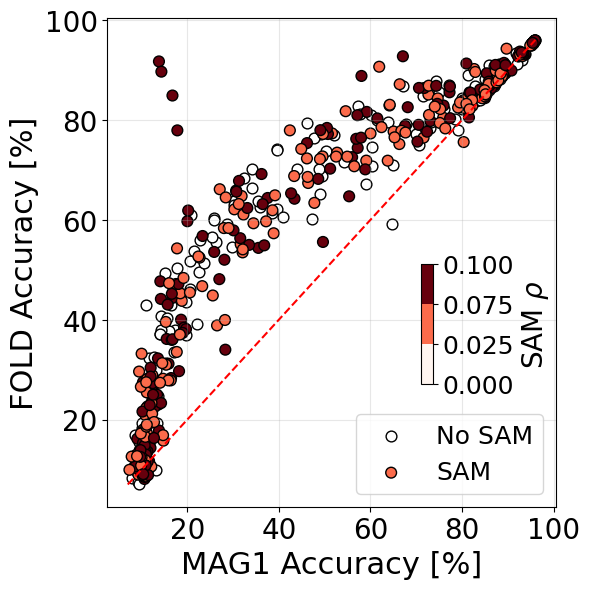

/tmp/ipython-input-2449188874.py:20: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged["raug"] = merged["model"].str.extract(r"(?i)rand_aug=(True|False)", expand=False).map({"True": True, "False": False}).fillna(False)
/tmp/ipython-input-2449188874.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


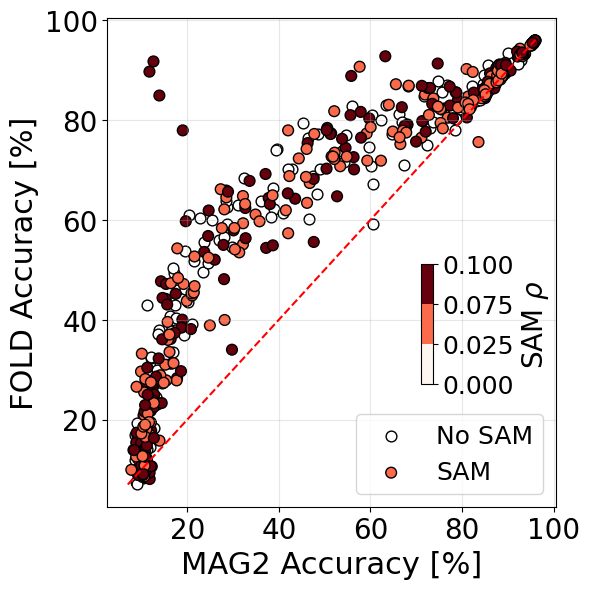

In [ ]:
def plot_fold_vs_method_sam(l1_target=0.0):
    # --- FOLD vs MAG colored by SAM ρ (WD==0 only), split by L1 ---
    rho_bins = np.array([0.0, 0.025, 0.075, 0.10])  # bin edges for colorbar
    norm = mcolors.BoundaryNorm(boundaries=rho_bins, ncolors=256)
    cmap = cm.Reds

    for method_name, method_df in zip(["MAG1","MAG2"], [mag_l1_df, mag_l2_df]):
        # merge on sure keys
        merged = pd.merge(
            fold_df[["model","ratio","acc_fold"]],
            method_df [["model","ratio","acc"]],
            on=["model","ratio"], how="inner"
        )
        if merged.empty:
            continue

        to_num = lambda s: pd.to_numeric(s, errors="coerce")

        merged["sam_rho"] = to_num(merged["model"].str.extract(r"sam_rho=([0-9.eE+-]+)", expand=False)).fillna(0.0)
        merged["raug"] = merged["model"].str.extract(r"(?i)rand_aug=(True|False)", expand=False).map({"True": True, "False": False}).fillna(False)

        subset = merged
        if subset.empty:
            continue

        fig, axes = plt.subplots(1, 1, figsize=(6, 6))
        for ax, l1_val in zip([axes], [l1_target]):
            df = subset

            # No SAM (white)
            ns = df[df["sam_rho"] == 0.0]
            if not ns.empty:
                ax.scatter(ns["acc"], ns["acc_fold"], c="white", edgecolor="black", s=60, label="No SAM")

            # SAM colored by ρ
            sm = df[df["sam_rho"] > 0.0]
            if not sm.empty:
                sc = ax.scatter(sm["acc"], sm["acc_fold"], c=sm["sam_rho"], cmap=cmap, norm=norm,
                                edgecolor="black", s=60, label="SAM")

            # y = x
            lo = df[["acc","acc_fold"]].min().min()
            hi = df[["acc","acc_fold"]].max().max()
            ax.plot([lo, hi], [lo, hi], "r--")

            ax.set_xlabel(f"{method_name} Accuracy [%]", fontsize=22)
            ax.set_ylabel("FOLD Accuracy [%]", fontsize=22)
            ax.tick_params(axis="both", labelsize=20)
            ax.legend(fontsize=18, loc="lower right")
            ax.grid(True, alpha=0.3)

        # shared colorbar (only meaningful if SAM points exist)
        if (subset["sam_rho"] > 0).any():
            cbar_ax = fig.add_axes([0.71, 0.35, 0.02, 0.2])
            smap = cm.ScalarMappable(norm=norm, cmap=cmap)
            cbar = fig.colorbar(smap, cax=cbar_ax, ax=axes, fraction=0.035, pad=0.02)
            cbar.set_label(r"SAM $\rho$", fontsize=20)
            cbar.set_ticks(rho_bins)
            cbar.set_ticklabels([f"{b:.3f}" for b in rho_bins])
            cbar.ax.tick_params(labelsize=18)

        fig.tight_layout()
        fig.savefig(f"{opt_name}__sam_scatter__{method_name}_vs_FOLD_l1_{l1_target}.png", dpi=100)
        plt.show()


fold_df  = extract_data(fold_text).rename(columns={"acc_after": "acc_fold"})
mag_l1_df = extract_data(mag1_text).rename(columns={"acc_after": "acc"})
mag_l2_df = extract_data(mag2_text).rename(columns={"acc_after": "acc"})

plot_fold_vs_method_sam()

/tmp/ipython-input-2391523375.py:51: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged["raug"] = merged["model"].str.extract(r"(?i)rand_aug=(True|False)", expand=False).map({"True": True, "False": False}).fillna(False)
/tmp/ipython-input-2391523375.py:128: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


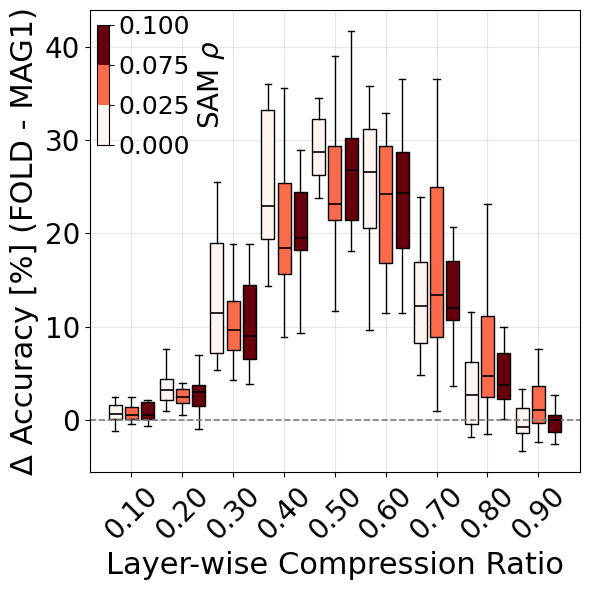

/tmp/ipython-input-2391523375.py:51: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged["raug"] = merged["model"].str.extract(r"(?i)rand_aug=(True|False)", expand=False).map({"True": True, "False": False}).fillna(False)
/tmp/ipython-input-2391523375.py:128: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


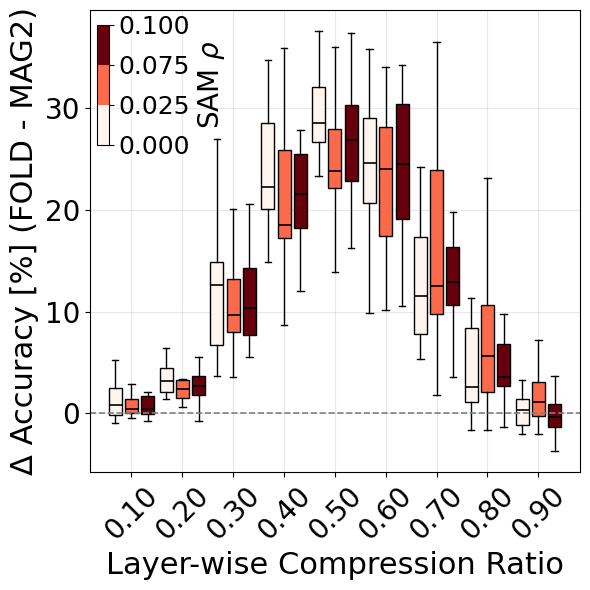

In [ ]:
def plot_fold_vs_method_box_by_ratio_sam(l1_target=0.0):
    # --- config for SAM ρ binning & colors ---
    rho_bins = np.array([0.0, 0.025, 0.075, 0.10])  # [0, 0.025), [0.025, 0.075), [0.075, 0.10]
    norm = mcolors.BoundaryNorm(boundaries=rho_bins, ncolors=256)
    cmap = cm.Reds

    def rho_bin_label(low, high):
        # closed on left, open on right except final bin which is closed-closed for labeling clarity
        if high == rho_bins[-1]:
            return f"[{low:.3f}, {high:.3f}]"
        return f"[{low:.3f}, {high:.3f})"

    # helper for grouped positions (group = rho-bin within each ratio)
    def grouped_positions(x_vals, n_groups, width=0.20):
        offsets = np.linspace(-((n_groups-1)/2)*width, ((n_groups-1)/2)*width, n_groups)
        return {gi: (np.asarray(x_vals) + offsets[gi]) for gi in range(n_groups)}, width

    # Precompute discrete bin colors and labels
    bin_edges = list(zip(rho_bins[:-1], rho_bins[1:]))
    bin_labels = [rho_bin_label(a, b) for a, b in bin_edges]
    # sample the colormap at bin midpoints for consistent box colors
    bin_mids = [(a + b) / 2.0 for a, b in bin_edges]
    bin_colors = [cmap(norm(m)) for m in bin_mids]

    # Map ρ to bin index (-1 for exactly 0 with no SAM when bins start at 0.0; we still place it in first bin)
    def rho_to_bin_idx(r):
        # Put r=0 into the first bin [0,0.025)
        if r <= rho_bins[1] and r >= rho_bins[0]:
            return 0
        for i, (a, b) in enumerate(bin_edges):
            if (r >= a) and (r < b):
                return i
        # if equals last edge, place into last bin
        if np.isclose(r, rho_bins[-1]):
            return len(bin_edges) - 1
        return None

    for method_name, method_df in zip(["MAG1","MAG2"], [mag_l1_df, mag_l2_df]):
        # merge on sure keys
        merged = pd.merge(
            fold_df[["model","ratio","acc_fold"]],
            method_df[["model","ratio","acc"]],
            on=["model","ratio"], how="inner"
        )
        if merged.empty:
            continue

        to_num = lambda s: pd.to_numeric(s, errors="coerce")

        merged["sam_rho"] = to_num(merged["model"].str.extract(r"sam_rho=([0-9.eE+-]+)", expand=False)).fillna(0.0)
        merged["raug"] = merged["model"].str.extract(r"(?i)rand_aug=(True|False)", expand=False).map({"True": True, "False": False}).fillna(False)

        subset = merged

        # Δ accuracy = FOLD − method
        subset["diff"] = subset["acc_fold"] - subset["acc"]

        # Determine available ratios and valid rho-bin groups present in data
        all_ratios = sorted(subset["ratio"].unique())
        all_ratios = all_ratios[1:]
        # We'll use fixed bins defined by rho_bins; some bins may be empty for a given ratio/L1 panel

        # Figure setup: one row with 2 panels for l1 targets (if present)
        # present_l1 = [v for v in [l1_target] if v in subset["l1"].unique()]
        fig, axes = plt.subplots(1, 1, figsize=(6, 6), sharey=True)
        # if len(present_l1) == 1:
        axes = [axes]

        for ax, l1_val in zip(axes, [0.0]):
            df = subset
            # if df.empty:
            #     ax.set_visible(False)
            #     continue

            x = np.arange(len(all_ratios), dtype=float)
            n_groups = len(bin_edges)
            pos_map, box_w = grouped_positions(x, n_groups, width=0.32)

            # Build and draw boxplots per (ratio, rho-bin)
            for gi, (a, b) in enumerate(bin_edges):
                pos = pos_map[gi]
                data_for_boxes, valid_pos = [], []
                for r_i, r in enumerate(all_ratios):
                    vals = df[(df["ratio"] == r) &
                              (df["sam_rho"] >= a) &
                              (df["sam_rho"] <  b if b < rho_bins[-1] else df["sam_rho"] <= b)
                            ]["diff"].tolist()
                    if vals:
                        data_for_boxes.append(vals)
                        valid_pos.append(pos[r_i])
                if data_for_boxes:
                    bp = ax.boxplot(
                        data_for_boxes,
                        positions=valid_pos,
                        widths=box_w*0.8,
                        patch_artist=True,
                        showfliers=False
                    )
                    # style
                    for patch in bp["boxes"]:
                        patch.set(facecolor=bin_colors[gi], alpha=1.0, edgecolor="black")
                    for whisk in bp["whiskers"]:
                        whisk.set(color="black", linewidth=1)
                    for cap in bp["caps"]:
                        cap.set(color="black", linewidth=1)
                    for median in bp["medians"]:
                        median.set(color="black", linewidth=1.2)

            # aesthetics
            ax.set_xlabel("Layer-wise Compression Ratio", fontsize=22)
            ax.set_xticks(x)
            ax.set_xticklabels([f"{r:.2f}" if isinstance(r, float) else str(r) for r in all_ratios], rotation=45, fontsize=20)
            ax.axhline(0.0, color="gray", linestyle="--", linewidth=1.2)  # accuracy gain = 0
            ax.tick_params(axis="y", labelsize=20)
            ax.grid(True, alpha=0.3)

        axes[0].set_ylabel(f"Δ Accuracy [%] (FOLD - {method_name})", fontsize=22)

        if (subset["sam_rho"] > 0).any():
            cbar_ax = fig.add_axes([0.17, 0.75, 0.02, 0.2])
            smap = cm.ScalarMappable(norm=norm, cmap=cmap)
            cbar = fig.colorbar(smap, cax=cbar_ax, ax=axes, fraction=0.035, pad=0.02)
            cbar.set_label(r"SAM $\rho$", fontsize=20)
            cbar.set_ticks(rho_bins)
            cbar.set_ticklabels([f"{b:.3f}" for b in rho_bins])
            cbar.ax.tick_params(labelsize=18)

        plt.tight_layout()
        fig.savefig(f"{opt_name}__sam_hist__{method_name}_vs_FOLD_l1_{l1_target}.png", dpi=100)
        plt.show()


fold_df  = extract_data(fold_text).rename(columns={"acc_after": "acc_fold"})
mag_l1_df = extract_data(mag1_text).rename(columns={"acc_after": "acc"})
mag_l2_df = extract_data(mag2_text).rename(columns={"acc_after": "acc"})

plot_fold_vs_method_box_by_ratio_sam()


#Full Fine-tuning

In [ ]:
# Load text content
with open(f"fold", "r") as f:
    fold_text = f.read()
with open(f"mag-l1", "r") as f:
    mag1_text = f.read()
with open(f"mag-l2", "r") as f:
    mag2_text = f.read()

/tmp/ipython-input-1635290762.py:101: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


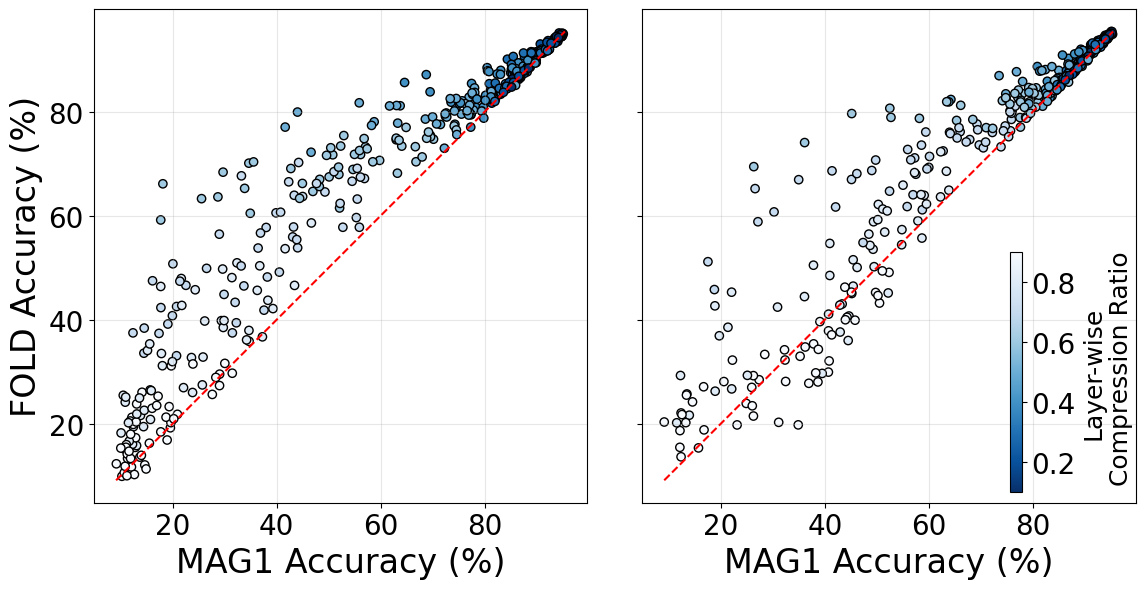

/tmp/ipython-input-1635290762.py:101: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


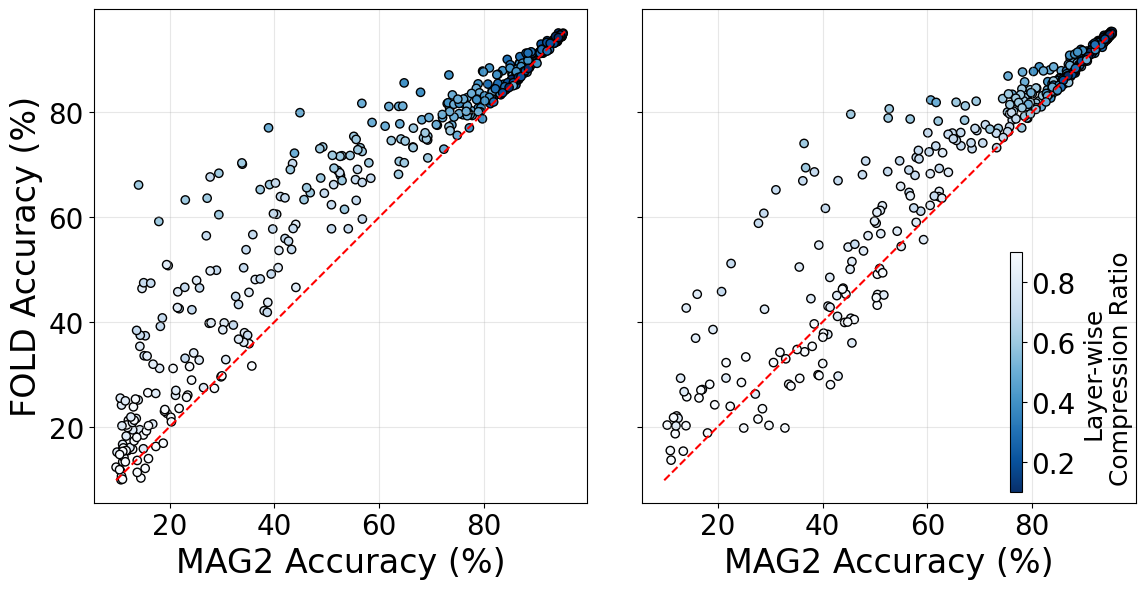

In [ ]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# ---- Parse FINETUNE_EPOCH accuracies, using the new extractor for filtering (optional) ----
def parse_epoch_acc_with_extractor(text, include=None, exclude=None):
    """
    Returns: DataFrame with columns [model_id, model, ratio (printed), epoch, acc]
    Uses extract_data(text, include=..., exclude=...) only to choose which [MODEL] blocks to keep.
    """
    keep = extract_data(text, include=include, exclude=exclude)
    keep_models = set(keep["model"].unique()) if not keep.empty else set()

    rows = []
    block_re = re.compile(r"\[MODEL\]\s+(\d+)/\d+\s+(.*?)\.pth(.*?)(?=\[MODEL\]|\Z)", re.DOTALL)
    for mid, name, block in block_re.findall(text):
        mid = int(mid); name = name.strip()
        if keep_models and name not in keep_models:
            continue

        for r, ep, acc in re.findall(r"RATIO=([\d.]+)\s+EVENT=FINETUNE_EPOCH(\d+)\s+acc=([\d.]+)", block):
            rows.append({
                "model_id": mid,
                "model": name,
                "ratio": float(r),          # keep printed RATIO (do not remap)
                "epoch": int(ep),
                "acc": float(acc),
            })
    return pd.DataFrame(rows)

# -------- Extract data (rename acc columns) --------
fold_df = parse_epoch_acc_with_extractor(fold_text, include={"l1": 0.0}).rename(columns={"acc": "acc_fold"})
mag_l1_df = parse_epoch_acc_with_extractor(mag1_text, include={"l1": 0.0}).rename(columns={"acc": "acc"})
mag_l2_df = parse_epoch_acc_with_extractor(mag2_text, include={"l1": 0.0}).rename(columns={"acc": "acc"})

for method_name, method_df in zip(["MAG1","MAG2"], [mag_l1_df, mag_l2_df]):
    # Keep epochs 1 and 5
    epochs_to_show = [1, 5]
    fold_df = fold_df[fold_df["epoch"].isin(epochs_to_show)]
    method_df = method_df[method_df["epoch"].isin(epochs_to_show)]

    # Merge by model_id, model, ratio, epoch
    merged = pd.merge(
        fold_df, method_df,
        on=["model_id", "model", "ratio", "epoch"],
        how="inner"
    )

    # ---- Plot (keep your font sizes & style) ----
    if merged.empty:
        print("No overlapping FINETUNE_EPOCH entries to plot.")
    else:
        fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

        cmap = cm.Blues_r
        norm = mcolors.Normalize(vmin=merged["ratio"].min(), vmax=merged["ratio"].max())

        # common limits across both panels to keep the y=x diagonal comparable
        global_lo = merged[["acc", "acc_fold"]].min().min()
        global_hi = merged[["acc", "acc_fold"]].max().max()

        for i, ep in enumerate(epochs_to_show):
            ax = axes[i]
            data = merged[merged["epoch"] == ep]
            if data.empty:
                ax.set_visible(False)
                continue

            ax.scatter(
                data["acc"], data["acc_fold"],
                c=cmap(norm(data["ratio"].values)),
                edgecolors="black"
            )

            # Diagonal y = x
            ax.plot([global_lo, global_hi], [global_lo, global_hi], 'r--', alpha=1.0)

            # Labels & style (keep your sizes)
            # ax.set_title(f"Fine-tune Epoch {ep}", fontsize=24)
            ax.set_xlabel(f"{method_name} Accuracy (%)", fontsize=24)
            if i == 0:
                ax.set_ylabel("FOLD Accuracy (%)", fontsize=24)

            ax.set_aspect('equal', adjustable='box')
            ax.tick_params(axis='both', which='major', labelsize=20)
            ax.grid(True, alpha=0.3)

        plt.tight_layout()

        # Shared colorbar (no manual cax → no tight_layout warning)
        sm = cm.ScalarMappable(norm=norm, cmap=cmap)
        sm.set_array([])
        cax = fig.add_axes([0.86, 0.17, 0.01, 0.4])
        cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax)
        cbar.set_label("Layer-wise\n Compression Ratio", fontsize=18)
        cbar.ax.tick_params(labelsize=20)

        fig.tight_layout()
        fig.savefig(f"{opt_name}__fold_vs_{method_name}_after_ft.png", dpi=100)
        plt.show()


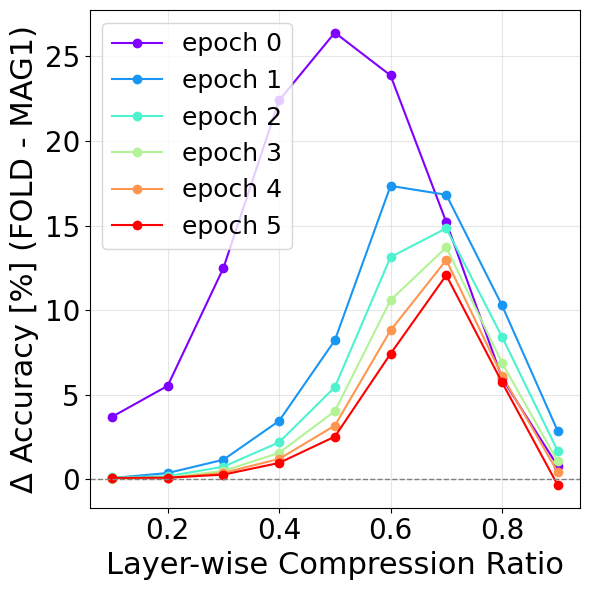

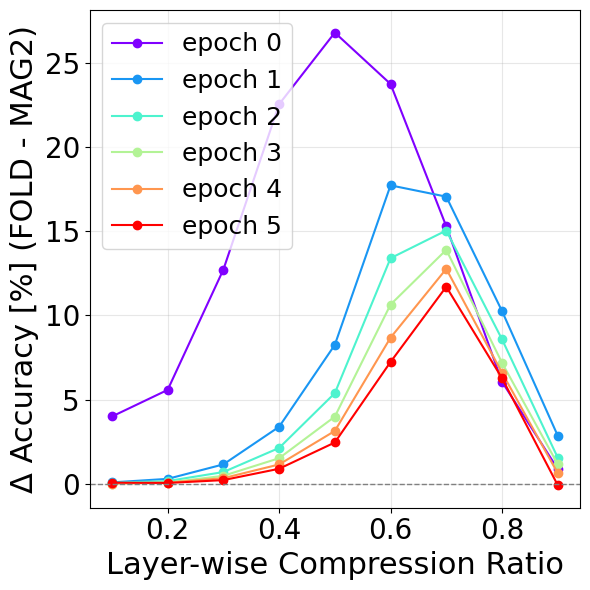

In [ ]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# --- Parse REPAIR (epoch 0) and FINETUNE_EPOCHx (epochs 1..5) using the new extractor for filtering ---
def parse_epoch_acc_with_extractor(text, include=None, exclude=None):
    """
    Returns: DataFrame[model_id, model, ratio (printed), epoch, test_acc]
    - Uses extract_data(text, include=..., exclude=...) ONLY to choose which [MODEL] blocks to keep.
    - Pairs each REPAIR / FINETUNE_EPOCH line with its own printed RATIO directly (no stateful carryover).
    """
    keep = extract_data(text, include=include, exclude=exclude)
    keep_models = set(keep["model"].unique()) if not keep.empty else set()

    rows = []
    block_re = re.compile(r"\[MODEL\]\s+(\d+)/\d+\s+(.*?)\.pth(.*?)(?=\[MODEL\]|\Z)", re.DOTALL)
    for mid, name, block in block_re.findall(text):
        mid = int(mid); name = name.strip()
        if keep_models and name not in keep_models:
            continue

        # REPAIR (epoch 0): ratio and acc on the SAME line
        for r, acc in re.findall(r"RATIO=([0-9.]+)\s+EVENT=REPAIR\s+acc=([0-9.]+)", block):
            rows.append((mid, name, float(r), int(0), float(acc)))

        # FINETUNE_EPOCHk: ratio and acc on the SAME line
        for r, ep, acc in re.findall(r"RATIO=([0-9.]+)\s+EVENT=FINETUNE_EPOCH(\d+)\s+acc=([0-9.]+)", block):
            rows.append((mid, name, float(r), int(ep), float(acc)))

    return pd.DataFrame(rows, columns=["model_id", "model", "ratio", "epoch", "test_acc"])


# -------- Extract for both methods (add include/exclude filters if you want) --------
fold_df = parse_epoch_acc_with_extractor(fold_text, include={"l1": 0.0}).rename(columns={"test_acc": "acc_fold"})
mag1_df = parse_epoch_acc_with_extractor(mag1_text, include={"l1": 0.0}).rename(columns={"test_acc": "acc"})
mag2_df = parse_epoch_acc_with_extractor(mag2_text, include={"l1": 0.0}).rename(columns={"test_acc": "acc"})

for method_name, method_df in zip(["MAG1","MAG2"], [mag1_df, mag2_df]):
    # Merge on model identity + ratio + epoch (model_id alone can collide across logs)

    merged = pd.merge(
        fold_df, method_df,
        on=["model", "ratio", "epoch"],
        how="inner"
    )

    if merged.empty:
        print("No overlapping REPAIR/FINETUNE entries between FOLD and MAG-L1.")
    else:
        # Relative gain: FOLD - MAG-L1 (same style as your original)
        merged["rel_gain"] = merged["acc_fold"] - merged["acc"]

        # Mean gain per pruning ratio and epoch
        mean_gain = (merged.groupby(["ratio", "epoch"])["rel_gain"]
                            .mean()
                            .reset_index()
                            .sort_values(["epoch", "ratio"]))

        # ---- Plot (keep your style & font sizes) ----
        fig, ax = plt.subplots(figsize=(6, 6))
        epochs = sorted(mean_gain["epoch"].unique())
        colors = cm.rainbow(np.linspace(0, 1, len(epochs)))

        for ep, c in zip(epochs, colors):
            d = mean_gain[mean_gain["epoch"] == ep]
            ax.plot(d["ratio"], d["rel_gain"], "o-", color=c, label=f"epoch {ep}")

        ax.axhline(0, color="gray", ls="--", lw=1)
        ax.set_xlabel("Layer-wise Compression Ratio", fontsize=22)
        ax.set_ylabel(f"Δ Accuracy [%] (FOLD - {method_name})", fontsize=22)
        ax.tick_params(labelsize=20)
        ax.legend(fontsize=18)
        ax.grid(True, alpha=0.3)

        plt.tight_layout()
        fig.savefig(f"{opt_name}__fold_vs_{method_name}_after_ft_gain.png", dpi=100)
        plt.show()


/tmp/ipython-input-387700988.py:76: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


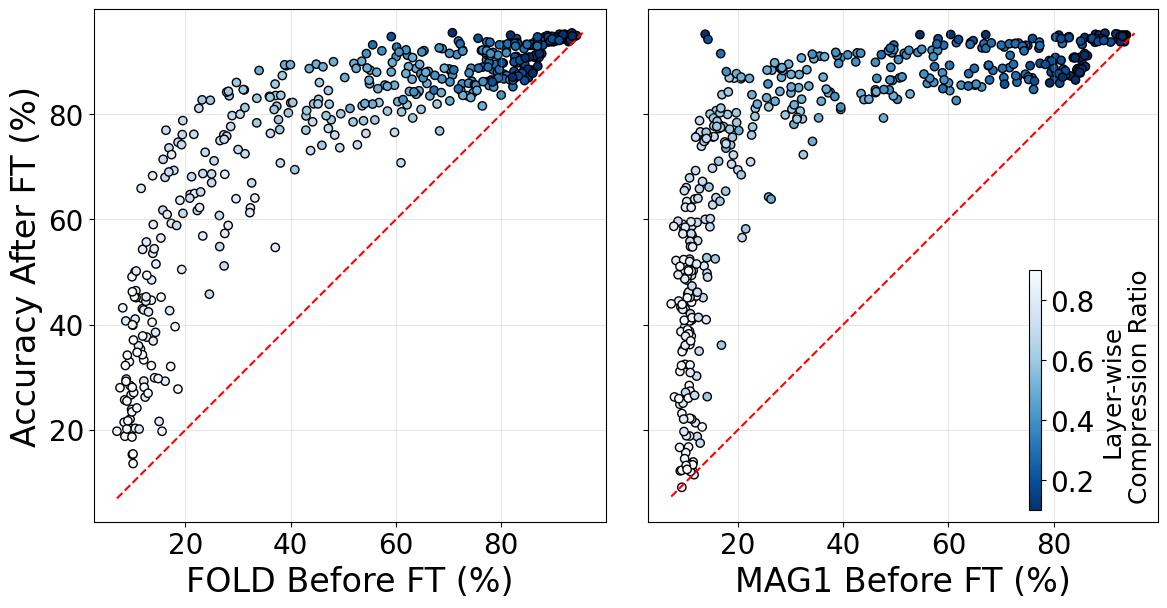

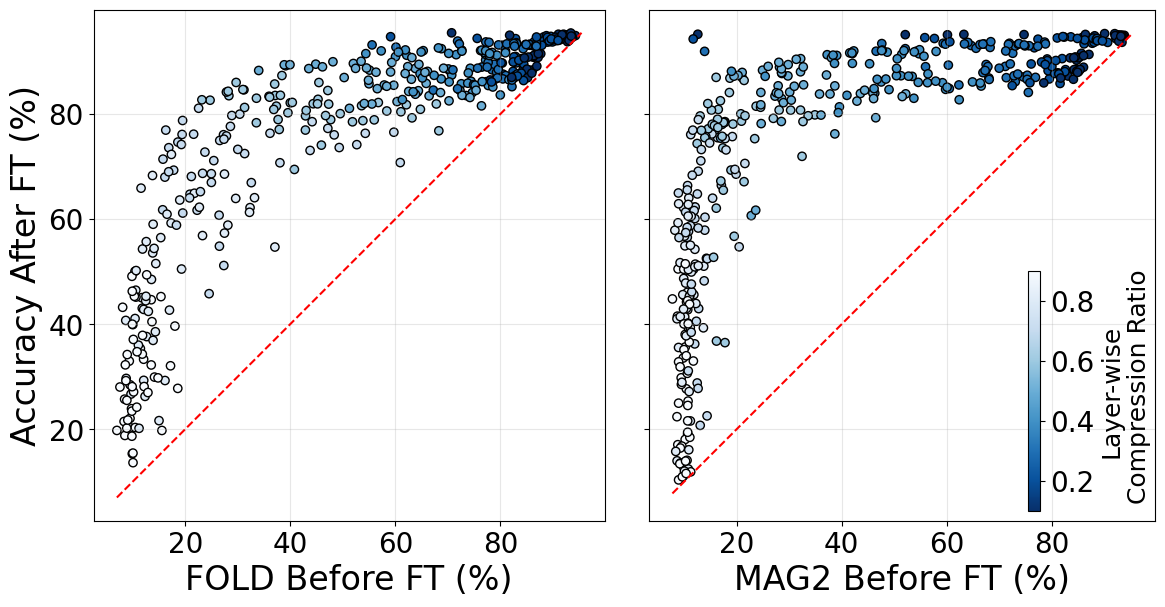

In [ ]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# --- Before/After FT5 using the unified extractor for filtering ---
def extract_before_after_ft(text, include=None, exclude=None):
    """
    Return DataFrame: model_id | model | ratio (printed) | before_acc (REPAIR) | after_acc (FINETUNE_EPOCH5)
    Uses `extract_data(text, include=..., exclude=...)` ONLY to decide which [MODEL] blocks to keep.
    """
    keep = extract_data(text, include=include, exclude=exclude)
    keep_models = set(keep["model"].unique()) if not keep.empty else set()

    rows = []
    block_re = re.compile(r"\[MODEL\]\s+(\d+)/\d+\s+(.*?)\.pth(.*?)(?=\[MODEL\]|\Z)", re.DOTALL)
    for mid, name, block in block_re.findall(text):
        mid = int(mid); name = name.strip()
        if keep_models and name not in keep_models:
            continue

        # collect REPAIR and FT5 per printed ratio
        repairs = {float(r): float(a) for r, a in re.findall(
            r"RATIO=([0-9.]+)\s+EVENT=REPAIR\s+acc=([0-9.]+)", block)}
        ft5 = {float(r): float(a) for r, a in re.findall(
            r"RATIO=([0-9.]+)\s+EVENT=FINETUNE_EPOCH5\s+acc=([0-9.]+)", block)}

        for r in sorted(set(repairs) & set(ft5)):
            rows.append((mid, name, r, repairs[r], ft5[r]))

    return pd.DataFrame(rows, columns=["model_id", "model", "ratio", "before_acc", "after_acc"])


# --- Load logs (filter via include/exclude if desired) ---
fold_df = extract_before_after_ft(fold_text, include={"l1": 0.0})
mag1_df = extract_before_after_ft(mag1_text, include={"l1": 0.0})
mag2_df = extract_before_after_ft(mag2_text, include={"l1": 0.0})

for method_name, method_df in zip(["MAG1","MAG2"], [mag1_df, mag2_df]):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

    combined_ratios = pd.concat([d["ratio"] for d in [fold_df, method_df] if not d.empty])
    norm = mcolors.Normalize(vmin=combined_ratios.min(), vmax=combined_ratios.max())
    cmap = cm.Blues_r

    def plot_method(ax, df, name):
        sc = ax.scatter(
            df["before_acc"], df["after_acc"],
            c=cmap(norm(df["ratio"].values)), edgecolors="black"
        )
        lo = min(df["before_acc"].min(), df["after_acc"].min())
        hi = max(df["before_acc"].max(), df["after_acc"].max())
        ax.plot([lo, hi], [lo, hi], 'r--', alpha=1.0)
        ax.set_xlabel(f"{name} Before FT (%)", fontsize=24)
        ax.set_aspect('equal', adjustable='box')
        ax.tick_params(axis='both', labelsize=20)
        return sc

    for ax, tdf, name in zip(axes, [fold_df, method_df], ["FOLD", method_name]):
        if tdf.empty:
            continue
        plot_method(ax, tdf, name)
        ax.grid(True, alpha=0.3)

    axes[0].set_ylabel("Accuracy After FT (%)", fontsize=24)


    # Shared colorbar (attach to axes to avoid tight_layout issues)
    cax = fig.add_axes([0.87, 0.14, 0.01, 0.4])
    cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax)
    cbar.set_label("Layer-wise\n Compression Ratio", fontsize=18)
    cbar.ax.tick_params(labelsize=20)

    fig.tight_layout()
    fig.savefig(f"{opt_name}__fold_and_{method_name}_before_and_after_ft.png", dpi=100)
    plt.show()


In [ ]:
!zip out.zip *.png

  adding: preact_resnet__compression_ratio_hist__MAG1_vs_FOLD.png (deflated 11%)
  adding: preact_resnet__compression_ratio_hist__MAG2_vs_FOLD.png (deflated 11%)
  adding: preact_resnet__compression_ratio_scatter__MAG1_vs_FOLD.png (deflated 3%)
  adding: preact_resnet__compression_ratio_scatter__MAG2_vs_FOLD.png (deflated 3%)
  adding: preact_resnet__fold_and_MAG1_before_and_after_ft.png (deflated 4%)
  adding: preact_resnet__fold_and_MAG2_before_and_after_ft.png (deflated 4%)
  adding: preact_resnet__fold_vs_MAG1_after_ft_gain.png (deflated 4%)
  adding: preact_resnet__fold_vs_MAG1_after_ft.png (deflated 4%)
  adding: preact_resnet__fold_vs_MAG2_after_ft_gain.png (deflated 4%)
  adding: preact_resnet__fold_vs_MAG2_after_ft.png (deflated 4%)
  adding: preact_resnet__lr_hist__MAG1_vs_FOLD.png (deflated 10%)
  adding: preact_resnet__lr_hist__MAG2_vs_FOLD.png (deflated 10%)
  adding: preact_resnet__lr_scatter__MAG1_vs_FOLD.png (deflated 3%)
  adding: preact_resnet__lr_scatter__MAG2_vs_FOL